# Neural Memory Streaming Recommender Networks with Adversarial Training

NMRN is a streaming recommender model based on neural memory networks with external memories to capture and store both long-term stable interests and short-term dynamic interests in a unified way. An adaptive negative sampling framework based on Generative Adversarial Nets (GAN) is developed to optimize our proposed streaming recommender model, which effectively overcomes the limitations of classical negative sampling approaches and improves the effectiveness of the model parameter inference.

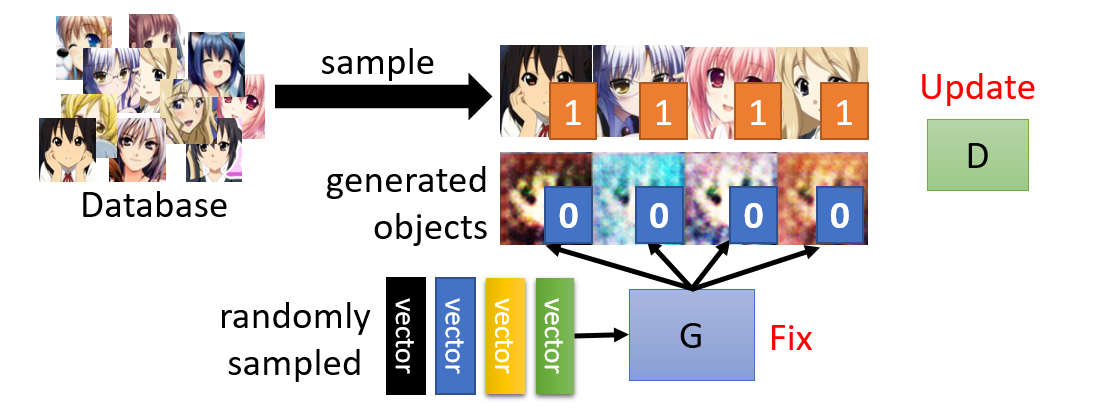

Specifically, the external memories of NMRN compose the key memory and the value memory. Given a new user-item interaction pair(u , v) arriving at the system in real time, NMRN first generates a soft address from the key memory, activated by u. The addressing process is inspired by recent advances in attention mechanism. The attention mechanism applied in recommender systems is useful to improve the retrieval accuracy and model interpretability. The fundamental idea of this attention design is to learn a weighted representation across the key memory, which is converted into a probability distribution by the Softmax function as the soft address.Then, NMRN reads from the value memory based on the soft address, resulting in a vector that represents both long-term stable and short-term emerging interests of user u. Inspired by the success of pairwise personalized ranking models (e.g., BPR) in top-k recommendations, we adopt the Hinge-loss in our model optimization. As the number of unobserved examples is very huge, we use the negative sampling method to improve the training efficiency.

Most existing negative sampling approaches use either random sampling or popularity-biased sampling strategies. However, the majority of negative examples generated in these sampling strategies can be easily discriminated from observed examples, and will contribute little towards the training, because sampled items could be completely unrelated to the target user. Besides, these sampling approaches are not adaptive enough to generate adversarial negative examples, because (1) they are static and thus do not consider that the estimated similarity or proximity between a user and an item changes during the learning process. For example, the similarity between user u and a sampled noise item v is high at the beginning, but after several gradient descent steps it becomes low; and (2) these samplers are global and do not reflect how informative a noise item is w.r.t. a specific user.

In light of this, we use an adaptive noise sampler based on a Generative Adversarial Network (GAN) to optimize the model, which considers both the specific user and the current values of the model parameters to adaptively generate “difficult” and informative negative examples. Moreover, in order to simultaneously capture the first-order similarity between users and items as well as the second-order similarities between users and between items to learn robust representations of users and items, we use the Euclidean distance to measure the similarity between a user and an item instead of the widely adopted dot product.

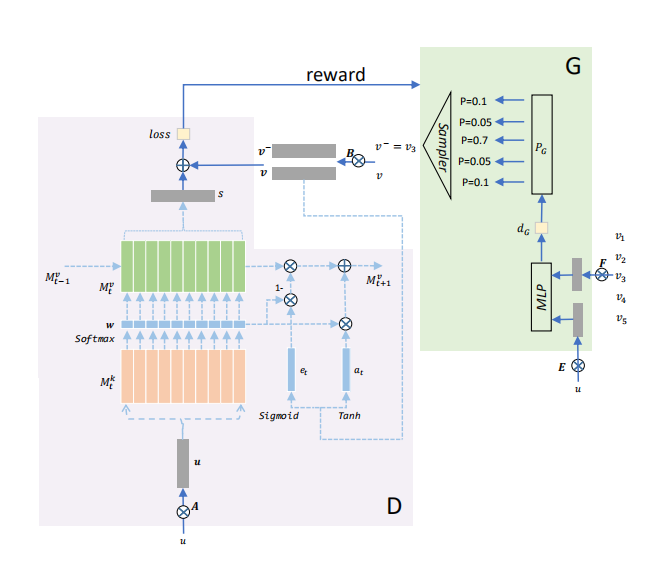



The Architecture of the model. The total numbers of users and items are denoted as $N$ and $M$. We denote a user-item interaction pair at time $t$ as $(u_t , v_t)$ while $v_t^-$ is a sampled negative item for a specific user at time $t$.

In [ ]:
import numpy as np 
import pandas as pd 

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.nn.parameter import Parameter
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader

from math import log

In [ ]:
#some parameters of this model
N, D_in, H = 64, 20, 10
safety_margin_size = 3
Max_sampleNum = 50
total_item_num = 500

In [ ]:
def euclidean_distance(a, b):
    return (a-b).pow(2).sum(1).sqrt()

In [ ]:
value_memory = torch.randn(H, D_in, requires_grad=True)
key_memory = torch.randn(H, D_in, requires_grad=True)

x = torch.randn(500, D_in)
y = torch.randn(500, D_in)

In [ ]:
class CandidateDataset(Dataset):
    def __init__(self, x, y):
        self.len = x.shape[0]
        self.x_data = torch.as_tensor(x,dtype=torch.float)
        self.y_data = torch.as_tensor(y,dtype=torch.float)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

In [ ]:
my_dataset = CandidateDataset(x, y)
train_loader = DataLoader(dataset = my_dataset, batch_size = 32, shuffle=True)

In [ ]:
class generator(nn.Module):
    def __init__(self, D_in):
        super(generator, self).__init__()

        self.fc1 = nn.Linear(2*D_in, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)  # Prob of Left

    def forward(self, x, y):
        cat_xy = torch.cat([x,y],1)
        hidden1 = F.relu(self.fc1(cat_xy))
        hidden2 = F.relu(self.fc2(hidden1))
        output = torch.sigmoid(self.fc3(hidden2))
        return output

In [ ]:
class Discriminator(torch.nn.Module):
    def __init__(self, D_in, H, N, key_memory, value_memory):
        super(Discriminator, self).__init__()
        self.key_memory = Parameter(torch.Tensor(H, D_in))
        self.value_memory = Parameter(torch.Tensor(H, D_in))
        self.key_memory.data = key_memory
        self.value_memory.data = value_memory
        #self.value_memory.requires_grad=True
        self.fc_erase = nn.Linear(D_in, D_in)
        self.fc_update = nn.Linear(D_in, D_in)
        self.D_in = D_in
        self.N = N
        self.H = H
    def forward(self, user, item):
        output_list = []
        e_I = torch.ones(self.H, self.D_in)
        
        for i in range(self.N):
            #Memory Adderssing
            Attention_weight = torch.empty(self.H)

            for j in range(self.H):
                Attention_weight[j] = -euclidean_distance(user[i].unsqueeze(0), self.key_memory[j,:])


            #select value memory by attention

            Attention_weight = Attention_weight.softmax(0)
            s = Attention_weight.matmul(self.value_memory)

            output = euclidean_distance(s, item[i].unsqueeze(0))
            output_list.append(output)
            
            #update value memory by item vector
            e_t = self.fc_erase(item[i].unsqueeze(0)).sigmoid()
            self.value_memory.data = self.value_memory * (e_I - Attention_weight.unsqueeze(0).t().matmul(e_t))

            a_t = self.fc_update(item[i].unsqueeze(0)).tanh()
            self.value_memory.data = self.value_memory + Attention_weight.unsqueeze(0).t().matmul(a_t)
        
        return output_list

In [ ]:
def ngtv_spl_by_unifm_dist(user):
    ngtv_item = torch.randn(1, D_in)
    return ngtv_item

def ngtv_spl_by_generator(user):
    ngtv_item_id = list(torch.multinomial(prob_ngtv_item, 1, replacement=True))[0]
    ngtv_item = dict_item_id2vec[candidate_ngtv_item[ngtv_item_id].item()]
    return ngtv_item_id, ngtv_item

def G_pretrain_per_datapoint(user, generator, model):
    ngtv_item_id, ngtv_item = generator(user)
    neg_rslt = model(user.unsqueeze(0), ngtv_item)[0]
    return -neg_rslt, ngtv_item_id

def D_pretrain_per_datapoint(user, item, generator):
    ps_rslt = model(user.unsqueeze(0),item.unsqueeze(0))[0]
    for i in range(Max_sampleNum):
        weight = log((total_item_num-1)//(i+1) + 1)
        neg_rslt = model(user.unsqueeze(0), generator(user))[0]
        loss = weighted_hinge_loss(ps_rslt, neg_rslt, safety_margin_size, weight)
        if(loss > 0):
            break;
    return loss
    
def weighted_hinge_loss(ps_rslt, neg_rslt, safety_margin_size, weight):
    return weight * F.relu(safety_margin_size + ps_rslt - neg_rslt)

In [ ]:
# pre-training of discriminator
model = Discriminator(20, 10, 1, key_memory, value_memory)
total_loss = []
optimizer = Adam(model.parameters(), lr= 0.01)

for epoch in range(50):
    epoch_loss = 0.
    for batch_id, (x, y) in enumerate(train_loader):
        losses = torch.empty(x.shape[0])
        for i in range(x.shape[0]):
            losses[i] = D_pretrain_per_datapoint(x[i],y[i], ngtv_spl_by_unifm_dist)

        mini_batch_loss = torch.sum(losses)
        epoch_loss += float(mini_batch_loss.data)
        
        model.zero_grad()
        mini_batch_loss.backward()
        optimizer.step()
        
    print('epoch_' + str(epoch) + ':  loss=' + str(epoch_loss))
    total_loss.append(epoch_loss)    

epoch_0:  loss=9162.51040649414
epoch_1:  loss=9512.62255859375
epoch_2:  loss=9214.800323486328
epoch_3:  loss=9504.176055908203
epoch_4:  loss=9284.231536865234
epoch_5:  loss=9422.251586914062
epoch_6:  loss=9421.282775878906
epoch_7:  loss=9396.276489257812
epoch_8:  loss=9390.662292480469
epoch_9:  loss=9425.124694824219
epoch_10:  loss=9205.153289794922
epoch_11:  loss=9452.185852050781
epoch_12:  loss=9485.987365722656
epoch_13:  loss=9410.585327148438
epoch_14:  loss=9127.744140625
epoch_15:  loss=9379.030639648438
epoch_16:  loss=9347.898803710938
epoch_17:  loss=9386.432373046875
epoch_18:  loss=9456.192657470703
epoch_19:  loss=9354.690643310547
epoch_20:  loss=9413.049743652344
epoch_21:  loss=9403.752807617188
epoch_22:  loss=9283.259490966797
epoch_23:  loss=9420.226654052734
epoch_24:  loss=9239.539581298828
epoch_25:  loss=9273.154418945312
epoch_26:  loss=9407.462158203125
epoch_27:  loss=9153.6669921875
epoch_28:  loss=9260.94091796875
epoch_29:  loss=9324.11300659179

In [ ]:
dict_user_id2vec = {}
dict_item_id2vec = {}
candidate_ngtv_item = torch.randn(100)
prob_ngtv_item = torch.randn(100)

In [ ]:
for i in candidate_ngtv_item:
    dict_item_id2vec[i.item()] = torch.randn(1,20)

## Training procedure

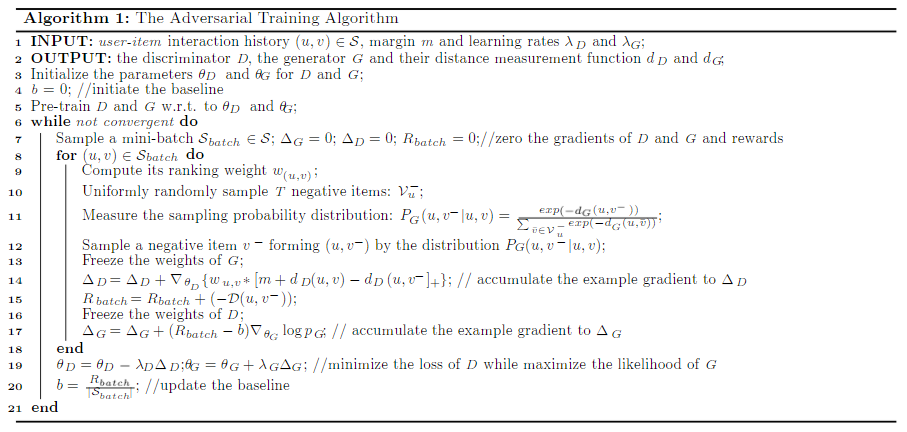

In [ ]:
#pre-training of generator
gener = generator(20)
total_reward = []
total_loss = []
optimizer_G = Adam(gener.parameters(), lr= 0.01)

for epoch in range(50):
    epoch_reward = 0.
    epoch_loss = 0.
    for batch_id, (x, y) in enumerate(train_loader):
        reward = torch.empty(x.shape[0])
        mini_batch_loss = torch.empty(x.shape[0])
        
        for data_point in range(x.shape[0]):
            #state = x[i]
            #action_pool = []
            #reward_pool = []
            candidate_ngtv_item = torch.randn(100)
            prob_ngtv_item = torch.randn(100)
            for i in candidate_ngtv_item:
                dict_item_id2vec[i.item()] = torch.randn(1,20)
            
            for i in range(candidate_ngtv_item.shape[0]):
                prob_ngtv_item[i] = gener(x[data_point].unsqueeze(0), dict_item_id2vec[candidate_ngtv_item[i].item()])
            prob_ngtv_item = torch.softmax(prob_ngtv_item,0)
            reward[data_point], ngtv_item_id = G_pretrain_per_datapoint(x[data_point], ngtv_spl_by_generator, model)
            mini_batch_loss[data_point] = (-reward[data_point]) * torch.log(prob_ngtv_item[ngtv_item_id])
        rewards = torch.sum(reward)
        mini_batch_losses = torch.sum(mini_batch_loss)
        epoch_loss = epoch + float(mini_batch_losses.data)
        epoch_reward = epoch + float(rewards.data)
        
        gener.zero_grad()
        mini_batch_losses.backward()
        optimizer_G.step()
    
    print('epoch_' + str(epoch) + ':  loss=' + str(epoch_loss) + '  reward=  ' + str(epoch_reward))
    total_loss.append(epoch_loss)  

epoch_0:  loss=-434.15869140625  reward=  -94.21874237060547
epoch_1:  loss=-424.1404113769531  reward=  -91.69937896728516
epoch_2:  loss=-436.8798522949219  reward=  -93.18343353271484
epoch_3:  loss=-454.4273681640625  reward=  -96.57652282714844
epoch_4:  loss=-436.4529113769531  reward=  -91.76925659179688
epoch_5:  loss=-421.24530029296875  reward=  -87.33723449707031
epoch_6:  loss=-413.3312683105469  reward=  -84.89115142822266
epoch_7:  loss=-394.2191162109375  reward=  -79.93122863769531
epoch_8:  loss=-415.0520324707031  reward=  -83.29130554199219
epoch_9:  loss=-380.2655029296875  reward=  -75.64791870117188
epoch_10:  loss=-404.0414733886719  reward=  -78.71047973632812
epoch_11:  loss=-370.0225830078125  reward=  -74.467041015625
epoch_12:  loss=-403.89019775390625  reward=  -78.97952270507812
epoch_13:  loss=-400.32525634765625  reward=  -77.73628234863281
epoch_14:  loss=-380.1445617675781  reward=  -73.97552490234375
epoch_15:  loss=-391.7283020019531  reward=  -74.83

## Links

[https://github.com/lzzscl/KBGAN-KV_MemNN/tree/master](https://github.com/lzzscl/KBGAN-KV_MemNN/tree/master/)

[Neural Memory Streaming Recommender Networks with Adversarial Training](https://dl.acm.org/doi/epdf/10.1145/3219819.3220004)